#Forecasting Temperature in Greenland
by Steven Newton

---

![greenland](https://ichef.bbci.co.uk/news/976/cpsprodpb/11E93/production/_108336337_mediaitem108336330.jpg)

The **Berkeley Earth Surface Temperature Study** combines 1.6 billion temperature reports from 16 archives. Berkeley publishes the source data and the code for the transformations applied.

Several files are included in [the Kaggle dataset](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data). For this brief project, I will be using mean monthly temperatures recorded in Greenland between 1823 and 2013.

The raw data, without transformations, comes from the [Berkeley Earth data page](http://berkeleyearth.org/data/).

In [6]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa import holtwinters
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Data dictionary

* *AverageTemperature*: global average land temperature in celsius (target variable)
* *AverageTemperatureUncertainty*: the 95% confidence interval around the average 

In [266]:
#Greenland temperatures taken from GlobalLandTemperaturesByCountry.csv
PATH = '/content/drive/MyDrive/Colab Notebooks/data/'

df = pd.read_csv(PATH+'GreenlandLandTemperatures.csv')
df.dt = pd.to_datetime(df.dt)
df = df.set_index('dt')
df = df.rename(columns={'AverageTemperature':'temp',
                        'AverageTemperatureUncertainty':'ci'})
df = df.iloc[:-1] #last row is missing

print(df.head(2))
print(df.tail(2))
print('\n')
df.info()

              temp     ci
dt                       
1823-01-01 -29.921  3.768
1823-02-01 -32.374  3.495
             temp     ci
dt                      
2013-07-01 -1.292  1.046
2013-08-01 -4.221  0.859


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2288 entries, 1823-01-01 to 2013-08-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    2288 non-null   float64
 1   ci      2288 non-null   float64
dtypes: float64(2)
memory usage: 53.6 KB


###Feature engineer

I'll make a rough season variable using months.

In [267]:
season_dict = {0:'winter', 1:'spring', 2:'summer', 3:'fall'}
season_idx = df.index.month % 12 // 3
df['season'] = season_idx.map(season_dict)

Annual temps reveal a warming period begun in the 1980s. Readings also become significantly more accurate over time as indicated by a tighter confidence interval. This increased accuracy is due in part to the switch from mercury to electronic thermometers. Incidentally, these same thermometers have a "cold bias" according to Berkeley, which their researchers account for by adding a bias term to inflate later readings.

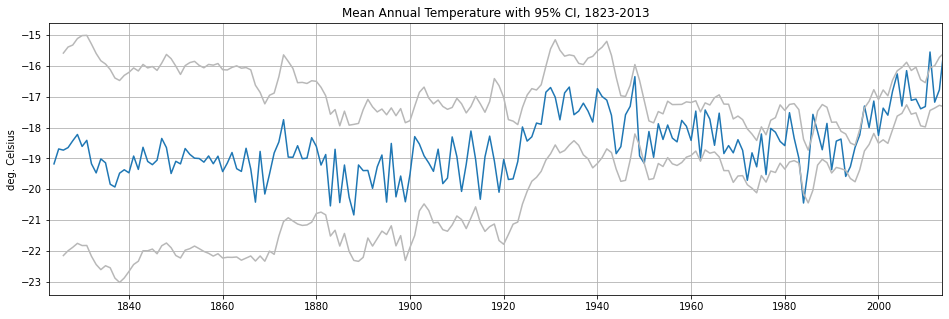

In [268]:
annual = df.resample('Y').mean()
f, ax = plt.subplots(figsize=(16,5))

sns.lineplot(data=annual.temp)
#plot confidence intervals with moving average
upper = (annual.temp+annual.ci).rolling(3).mean()
lower = (annual.temp-annual.ci).rolling(3).mean()
sns.lineplot(data=upper, color='#b8b8b8')
sns.lineplot(data=lower, color='#b8b8b8')

plt.title('Mean Annual Temperature with 95% CI, 1823-2013')
plt.ylabel('deg. Celsius')
plt.xlabel('')
plt.xlim(df.index[0], df.index[-1])
plt.grid()
plt.show()

Here is a close-up of the seasonal cycle during Abraham Lincoln's presidency. The cycle bottoms out in January and tops out in July, like all the rest of the Northern Hemisphere. It looks just like a sine wave. 

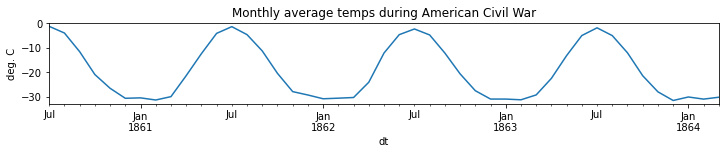

In [320]:
train.temp.iloc[450:495].plot(title='Monthly average temps during American Civil War',
                              ylabel="deg. C", figsize=(12,1.5));


##Split data
Train 1823-1953 / Validate 1954-1983 / Test 1984-2013

In [269]:
end_train, begin_test = 1953, 1984

test = df[df.index.year >= begin_test]
val = df[(df.index.year > end_train) & (df.index.year < begin_test)]
train = df[df.index.year <= end_train]

train.shape, val.shape, test.shape

((1572, 3), (360, 3), (356, 3))

##Explore

In [270]:
train.describe()

,temp,ci
count,1572.000000,1572.000000
mean,-18.821845,2.277309
std,10.908641,0.914813
min,-37.658000,0.457000
25%,-28.855250,1.537750
50%,-21.458000,2.133000
75%,-8.133250,2.982000
max,0.233000,8.425000


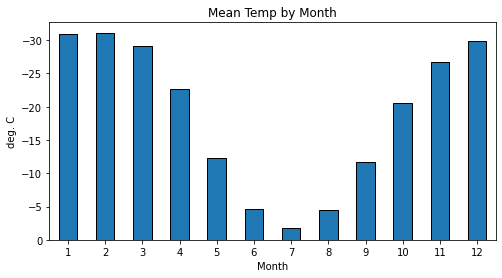

In [318]:
ax = train.temp.groupby(train.index.month).mean().plot.bar(width=.5,
                                                  figsize=(8,4), ec='black')
plt.xticks(rotation=0)
ax.invert_yaxis()
ax.set(title='Mean Temp by Month', xlabel='Month', ylabel='deg. C')
plt.show()

* Greenland must be cold! The mean temperature is below freezing in all but three months between 1823 and 1953. It turns out this data is reporting temperatures many degrees too low, according to Greenland's main travel site, even when considering only the coldest, northern towns like Upernavik. Here are the mean monthly temps reported by the government of Greenland.

 ![temps](https://visitgreenland.com/wp-content/uploads/2017/06/middeltemperaturer-greenland-dot-com-1-1400x807.jpg)

* I also notice four modes at -30 deg., -21 deg., -13 deg, and -5 deg., which I thought may represent the four seasons. Instead, the two extreme groups represent summer and winter while the middle two are a blend of fall and spring.
* The overall mean of the training data is -18.8 deg. I'll take it with a grain of salt but since the temps appear to be low across the board, time series modeling may not be affected. (Note that an averages of averages of subsets is the average of the whole set if the subsets are all the same sample size; 12 in this case.)

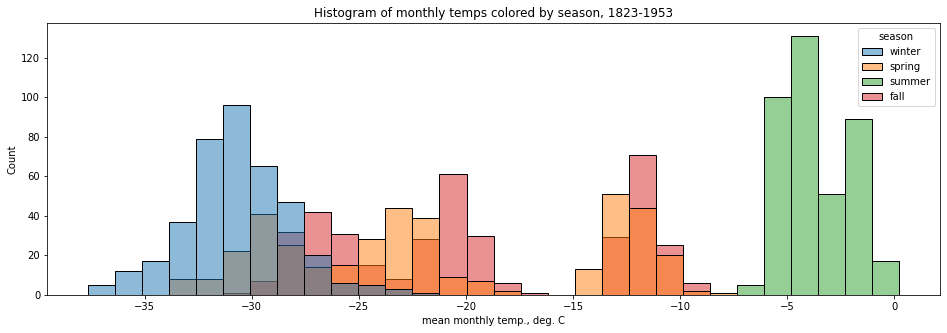

In [256]:
plt.figure(figsize=(16,5))
sns.histplot(data=train, x='temp', bins=30, hue='season')
plt.xlabel('mean monthly temp., deg. C')
plt.title('Histogram of monthly temps colored by season, 1823-1953')
plt.show()

Winters appear to have more variability than Summers.

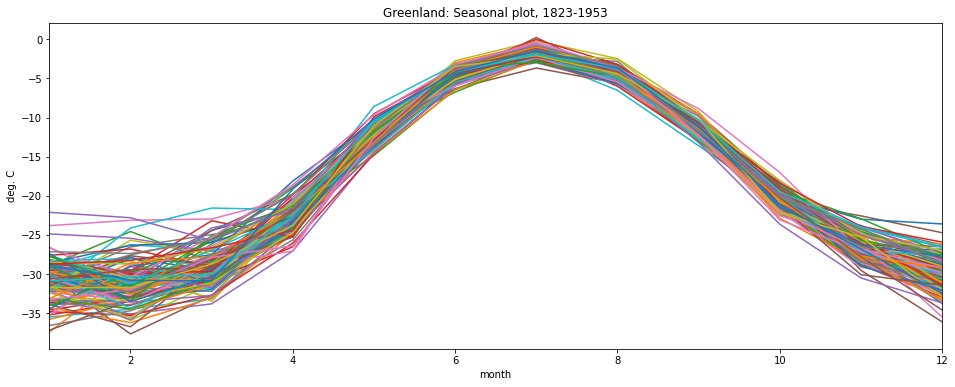

In [304]:
train.temp.groupby([train.index.year,
                    train.index.month]).mean().unstack(0).plot(figsize=(16,6))
plt.title('Greenland: Seasonal plot, 1823-1953')
plt.xlabel('month')
plt.ylabel('deg. C')
plt.xlim(1,12)
plt.legend().remove()

Let's look at moving averages.

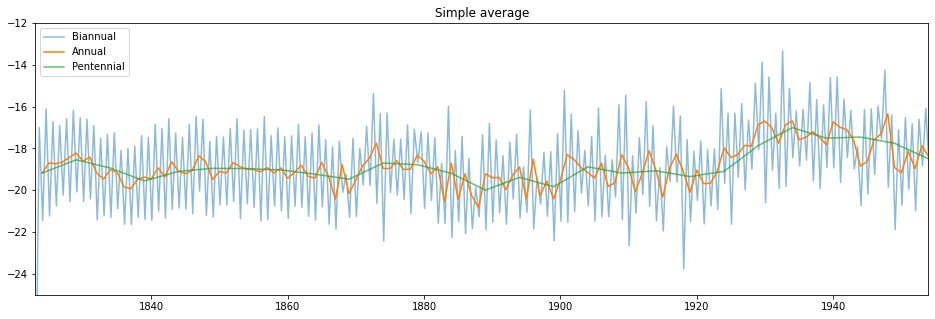

In [340]:
f, ax = plt.subplots(figsize=(16,5))

ax.plot(train.temp.resample('6M').mean(), alpha=.5, label='Biannual')
ax.plot(train.temp.resample('Y').mean(), label='Annual')
ax.plot(train.temp.resample('5Y').mean(), alpha=.7, label='Pentennial')

plt.title('Simple average')
plt.xlim(train.index[0], train.index[-1])
plt.ylim(-25,-12)

plt.legend()
plt.show()

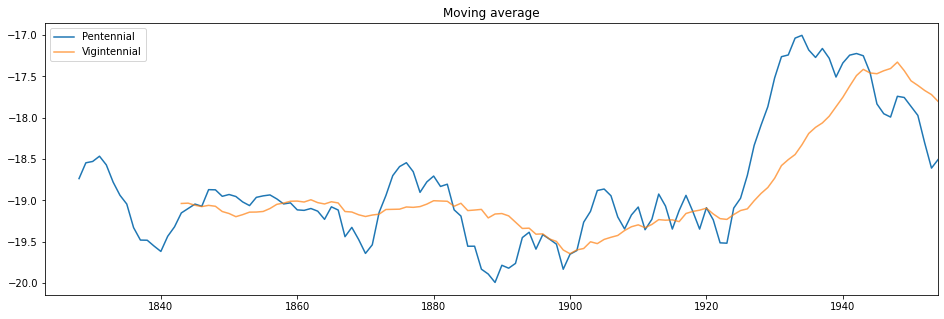

In [350]:
f, ax = plt.subplots(figsize=(16,5))

ax.plot(train.temp.resample('Y').mean().rolling(5).mean(), label='Pentennial')
ax.plot(train.temp.resample('Y').mean().rolling(20).mean(), alpha=.7, label='Vigintennial')

plt.title('Moving average')
plt.xlim(train.index[0], train.index[-1])
#plt.ylim(-25,-12)

plt.legend()
plt.show()

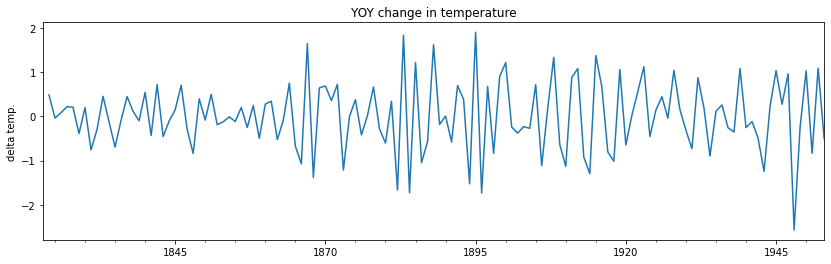

In [358]:
train.temp.resample('Y').mean().diff().plot(title='YOY change in temperature',
                                            xlabel='', ylabel='delta temp.',
                                            figsize=(14,4));

###Lag plot

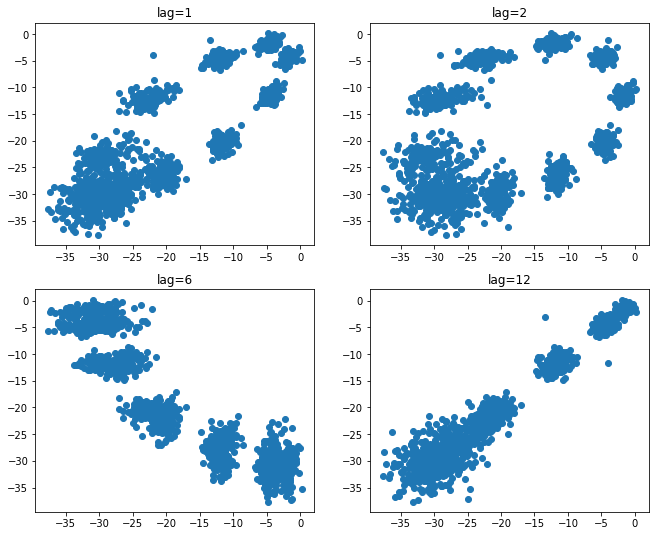

In [381]:
f, ax = plt.subplots(2,2, figsize=(11,9))

ax[0,0].scatter(train.temp, train.temp.shift(-1))
ax[0,0].set_title('lag=1')
ax[0,1].scatter(train.temp, train.temp.shift(-2))
ax[0,1].set_title('lag=2')
ax[1,0].scatter(train.temp, train.temp.shift(-6))
ax[1,0].set_title('lag=6')
ax[1,1].scatter(train.temp, train.temp.shift(-12))
ax[1,1].set_title('lag=12');

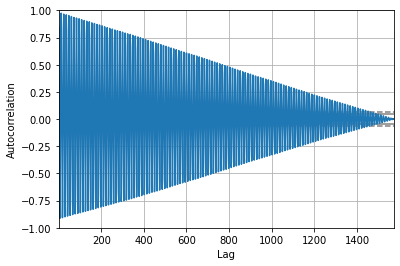

In [392]:
pd.plotting.autocorrelation_plot(train.temp.resample('M').mean());

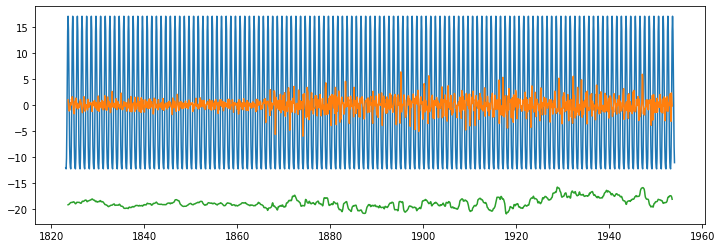

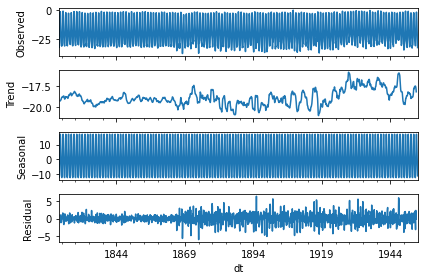

In [387]:
result = sm.tsa.seasonal_decompose(train.temp.resample('M').mean())

f, ax = plt.subplots(figsize=(12,4))
ax.plot(result.seasonal)
ax.plot(result.resid)
ax.plot(result.trend)
plt.show()
result.plot()
plt.show()

##Model

###Simple and moving average

In [258]:
#Simple average
print(f'\nRMSE for temp, simple average: {mean_squared_error(val.temp,\
                          np.zeros((len(val),))+train.temp.mean(), squared=False)}')
#Moving average
rmses = []
for p in range(1, 366):  
  pred = np.zeros((len(val),)) + train.temp.rolling(p).mean().iloc[-1]
  rmses.append(mean_squared_error(val.temp, pred, squared=False))

print(f'Best temp moving average: {1+np.argmin(rmses)}-day, RMSE {min(rmses)}')


RMSE for temp, simple average: 10.662492363435906
Best temp moving average: 60-day, RMSE 10.656614289048635


###Holt-Winters'

In [ ]:
sm.tsa.seasonal_decompose(train.temp.resample('M').mean()).plot()
plt.show()

#Holt's
mdl = holtwinters.ExponentialSmoothing(train.temp).fit(smoothing_level = .007,
                                                        smoothing_slope = 1)
#preds = mdl.predict(start = val.index[0], end = val.index[-1])
#print(f'RMSE for temp, Holt-Winters\': {mean_squared_error(val.temp, preds, squared=False)}\n')

###Previous cycle

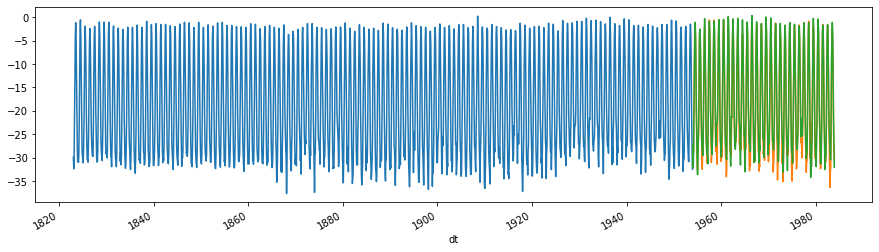

RMSE for temp, delta YOY: 2.6264375371981257


In [292]:
preds = train.temp.iloc[-len(val):] + train.temp.diff(len(val)).mean()
preds.index = val.index

train.temp.plot(figsize=(15,4))
val.temp.plot(figsize=(15,4))
preds.plot(figsize=(15,4))
plt.show()
  
print(f'RMSE for temp, delta YOY: {mean_squared_error(val.temp, preds, squared=False)}')